After the detailed analysis, applying different algorithms to improve the performance of the final metrics.

In [ ]:
# install necessaries libraries
! pip install ta
! pip install seglearn

# Load and transform data

In [ ]:
# Connecting to the google drive
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import RandomizedSearchCV

#picking models for prediction.
from sklearn.svm import SVC

In [ ]:
# file path
folder_path = '/content/drive/MyDrive/MADS_23_DL_final_project'
daily = pd.read_csv(folder_path + '/data/crypto_data_daily_cleaned_v1.csv')

In [ ]:
# view the first rows of dataset
daily.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto
0,2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC
1,2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC
2,2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC
3,2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC
4,2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC


### Create Train / Test Dataset

In [ ]:
# check the percentage of train / test set
daily['train_test'].value_counts(normalize=True)

Train    0.82546
Test     0.17454
Name: train_test, dtype: float64

In [ ]:
# create train & test datasets
df = daily.copy()

train_df = df[df['train_test']=='Train']
test_df = df[df['train_test']=='Test']

In [ ]:
train_df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto'],
      dtype='object')

In [ ]:
train_df.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto
0,2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC
1,2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC
2,2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC
3,2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC
4,2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC


### Data Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def minmax_scale(df_x, normalizers=None):


    #Try to pass the column values as a parameter from outside 
    features_to_minmax = ['Open','High', 'Low','Close','Volume']

    if not normalizers:
        normalizers = {}

    for feat in features_to_minmax:
        if feat not in normalizers:
            normalizers[feat] = MinMaxScaler()
            normalizers[feat].fit(df_x[feat].values.reshape(-1, 1))
        
        df_x[feat] = normalizers[feat].transform(df_x[feat].values.reshape(-1, 1))

    # series_y=normalizers["pct_change_2hour"].transform(series_y.values.reshape(-1, 1))

    return df_x , normalizers

In [ ]:
# since the model performs better without transformation, we do not apply this step
# train_df, train_normalizers = minmax_scale(train_df)
# test_df, test_normalizers = minmax_scale(test_df)

In [ ]:
train_df.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto
0,2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC
1,2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC
2,2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC
3,2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC
4,2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC


### Calculate percentage change

In [ ]:
# create function to calculate daily percentage change
def calculate_pct_change(df):
  coins = df.Crypto.unique()
  df_pct_change = pd.DataFrame()
  for coin in coins:
    x = df[df['Crypto']==coin]
    x['pct_change_1day'] = x['Close'].pct_change(1)
    df_pct_change = pd.concat([df_pct_change,x])
  return df_pct_change

In [ ]:
train_df = calculate_pct_change(train_df)
test_df = calculate_pct_change(test_df)

In [ ]:
test_df.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto,pct_change_1day
3098,2021-10-01,43828.89,48500.00,43287.44,48165.76,38375.517,Test,BTC,NaN
3099,2021-10-02,48185.61,48361.83,47438.00,47657.69,12310.011,Test,BTC,-0.010548
3100,2021-10-03,47649.00,49300.00,47119.87,48233.99,14411.104,Test,BTC,0.012092
3101,2021-10-04,48233.99,49530.53,46895.80,49245.54,25695.213,Test,BTC,0.020972
3102,2021-10-05,49244.13,51922.00,49057.18,51493.99,30764.491,Test,BTC,0.045658


# Generate new features

### Lag features, moving average, exponential moving average and market cap

In [ ]:
def create_market_volumn_features(df):
  
  # calculate value of each cryto at certain time points 
  df['Total_Value'] = df['Close']*df['Volume']
  # the sum of values at each time point
  sum_at_timepoints = df.groupby('Open Time').sum()['Total_Value']
  merged = df.merge(sum_at_timepoints, how='left',
                              on='Open Time', suffixes=('','_market'))
  merged['Value_Weight'] = merged['Total_Value']/merged['Total_Value_market']
    
  return merged

In [ ]:
# function to create shift features
def create_shift_features(df, col = 'pct_change_1day'):
    df['1_d_lag'] = df[col].shift(periods=1)
    return df

In [ ]:
#list to collect all relevant lags 
from ta import add_all_ta_features
def create_analysis_colums(df):

  master_df = pd.DataFrame()
  crypto_coins = df['Crypto'].unique()

  for coin in crypto_coins:
    
    temp_df = df[df['Crypto']==coin]
    temp_df['pct_change_1day'] = temp_df['Close'].pct_change()
    
    # temp_df = create_shift_features(temp_df.copy(),col = 'pct_change_1day',lags=5, freq='weekly')
    # temp_df = create_shift_features(temp_df.copy(),col = 'pct_change_1day',lags=2, freq='monthly')
    # temp_df = create_shift_features(temp_df.copy(),col = 'pct_change_1day',lags=4, freq='weekly')
    temp_df = create_shift_features(temp_df.copy(),col = 'pct_change_1day')
    temp_df = add_all_ta_features(temp_df.copy(), open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    if master_df.empty :
      master_df = temp_df
    else:
      master_df = pd.concat([master_df, temp_df])
  return master_df

In [ ]:
# create analysis columns for train and test dataset
train_df = create_analysis_colums(train_df)
test_df = create_analysis_colums(test_df)

In [ ]:
# check the columns of train dataset
train_df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto', 'pct_change_1day', '1_d_lag', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_

In [ ]:
# create market volume features 
train_df = create_market_volumn_features(train_df.copy())
test_df = create_market_volumn_features(test_df.copy())

In [ ]:
# check the columns of train_df
train_df.columns[:50]

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto', 'pct_change_1day', '1_d_lag', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg'],
      dtype='object')

In [ ]:
# choose features to keep for model training
feat_to_keep = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto', 'pct_change_1day'] #,'volatility_kcw','trend_cci','volume_adi','momentum_ppo_hist','momentum_stoch','volatility_kcp','volume_em',
            #  'volatility_dcw','volume_vpt','volatility_bbw','Total_Value', 'Total_Value_market', 'Value_Weight']
lag_cols = [col for col in train_df.columns if 'lag' in col]

feat_to_keep.extend(lag_cols)


In [ ]:
# check number of features to keep 
len(feat_to_keep)

10

In [ ]:
# filter train and set with only keep feature
train_df = train_df[feat_to_keep]
test_df = test_df[feat_to_keep]

In [ ]:
len(train_df.columns)

10

In [ ]:
# create function to calculate shift volume
def shift_vol(df):
  impo_feat = ['volatility_kcw','trend_cci','volume_adi','momentum_ppo_hist','momentum_stoch','volatility_kcp','volume_em',
              'volatility_dcw','volume_vpt','volatility_bbw']
  master_df = pd.DataFrame()
  crypto_coins = df['Crypto'].unique()


  for coin in crypto_coins:
    temp_df = df[df['Crypto']==coin]
    for feat in impo_feat:    

      temp_df[feat] = temp_df[feat].shift(1)
    if master_df.empty :
      master_df = temp_df
    else:
      master_df = pd.concat([master_df, temp_df])
  return master_df

# Extract year, month, day, hour and weekday from time stamp

### Encoding of ordinals

In [ ]:
# feature to encode ordinals
def encode_cyclicals(df_x):
    #"month","day","hour", "minute", "dayofweek"

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)
    
    df_x['day_sin'] = np.sin(2*np.pi*df_x.day/31)
    df_x['day_cos'] = np.cos(2*np.pi*df_x.day/31)
    df_x.drop('day', axis=1, inplace=True)

    df_x['dayofweek_sin'] = np.sin(2*np.pi*df_x.weekday/7)
    df_x['dayofweek_cos'] = np.cos(2*np.pi*df_x.weekday/7)
    df_x.drop('weekday', axis=1, inplace=True)
    
    df_x['hour_sin'] = np.sin(2*np.pi*df_x.hour/24)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.hour/24)
    df_x.drop('hour', axis=1, inplace=True)

    df_x['hour_sin'] = np.sin(2*np.pi*df_x.minute/60)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.minute/60)
    df_x.drop('minute', axis=1, inplace=True)
    
    return df_x

In [ ]:
# feature to measure date values extraction
def date_values_extraction(new_df):

  df = new_df.copy()
  df['year'] = pd.DatetimeIndex(df['Open Time']).year
  df['month'] = pd.DatetimeIndex(df['Open Time']).month
  df['day'] = pd.DatetimeIndex(df['Open Time']).day
  df['weekday'] = pd.DatetimeIndex(df['Open Time']).dayofweek


  df['Open Time'] = pd.to_datetime(df['Open Time'])
  df['minute'] = df['Open Time'].dt.minute
  df['hour'] = df['Open Time'].dt.hour
  df = encode_cyclicals(df.copy())
  return df

In [ ]:
# apply features on train and test dataset
train_df = date_values_extraction(train_df)
test_df = date_values_extraction(test_df)

## One hot coding the coins


In [ ]:
# choose time window and forecast distance to the future
TIME_WINDOW = 5
FORECAST_DISTANCE = 1

In [ ]:
# function to one hot encoding on Crypto Coin 
def crypto_one_hot_encoding(df):
  y_dummies = pd.get_dummies(df['Crypto'], prefix='Crypto', drop_first= False)
  # df = pd.concat([df, y_dummies], axis=1)
  # df.drop(['Crypto'], axis=1, inplace=True)
  # creating a additional column if the model is used for new coin.
  y_dummies['other_crypto'] =0
  return y_dummies

In [ ]:
# crete rolling data
def rolling_hot_data(train_df):
  train_hot = pd.DataFrame()
  for col in train_df.columns:
    if train_hot.empty:
        train_hot = train_df[train_df[col]==1][:-TIME_WINDOW]      
    else:
      train_hot = pd.concat([train_hot, train_df[train_df[col]==1][:-TIME_WINDOW]], axis=0)
  return train_hot

In [ ]:
crypto_one_hot_encoding(test_df).shape

(3621, 11)

In [ ]:
train_onehot_data = crypto_one_hot_encoding(train_df)
test_onehot_data = crypto_one_hot_encoding(test_df)

In [ ]:
train_onehot_data.describe()

,Crypto_ADA,Crypto_BTC,Crypto_ETC,Crypto_ETH,Crypto_LINK,Crypto_LTC,Crypto_TRX,Crypto_XLM,Crypto_XMR,Crypto_XRP,other_crypto
count,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.0
mean,0.076496,0.180905,0.101255,0.118131,0.048058,0.101255,0.084964,0.088234,0.101255,0.099445,0.0
std,0.265798,0.384951,0.301676,0.322773,0.213896,0.301676,0.278836,0.283643,0.301676,0.299268,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [ ]:
train_onehot_data = rolling_hot_data(train_onehot_data)
test_onehot_data = rolling_hot_data(test_onehot_data)

In [ ]:
train_onehot_data.shape, test_onehot_data.shape

((17075, 11), (3571, 11))

In [ ]:
train_df['pct_change_1day'].describe()

count    17115.000000
mean         0.005533
std          0.162083
min         -0.564847
25%         -0.025641
50%          0.000000
75%          0.028824
max         19.058824
Name: pct_change_1day, dtype: float64

In [ ]:
test_df['pct_change_1day'].describe()

count    3611.000000
mean       -0.001452
std         0.046840
min        -0.204696
25%        -0.026274
50%         0.000000
75%         0.024091
max         0.344702
Name: pct_change_1day, dtype: float64

In [ ]:
train_df = train_df.replace(np.NaN,0)
test_df = test_df.replace(np.NaN,0)

# Defining the Target Variable. 

We want to follow the classification approach and hence based on the "pct_change_2hour" we are creating 2 classes one class '0' when the returns are negative and '1' When the retruns are postive.

In [ ]:
# create taraget variable for model
def create_target(df, prob='Classification'):
  if prob == 'Classification':
    market_RoR = 26.89
    market_RoR_1d = market_RoR/365
    df['Target'] = np.where(df['pct_change_1day']>0, 1,0)
    df['Target'] = np.where(df['pct_change_1day']>market_RoR_1d, 2,1)
    df['Target'][df['Target']==1] = np.where(df['pct_change_1day'][df['Target']==1]>=0, 1,0)
  elif prob == 'Regression': 
    df['Target'] = df['pct_change_1day']
  return df

In [ ]:
# create target variable for regression model
train_df = create_target(train_df, 'Regression')
test_df = create_target(test_df, 'Regression')

In [ ]:
# check target values of train_df
train_df['Target'].value_counts(normalize=True)

 0.000000    0.059445
 0.071429    0.001635
 0.045455    0.001460
 0.043478    0.001343
 0.066667    0.001343
               ...   
 0.002939    0.000058
-0.003848    0.000058
 0.030492    0.000058
 0.015801    0.000058
 0.033752    0.000058
Name: Target, Length: 13919, dtype: float64

In [ ]:
# check target values of test_df
test_df['Target'].value_counts(normalize=True)

 0.000000    0.032035
 0.015873    0.002209
 0.015385    0.001657
 0.016949    0.001657
-0.016667    0.001381
               ...   
-0.070367    0.000276
 0.001066    0.000276
-0.048456    0.000276
 0.043649    0.000276
-0.002159    0.000276
Name: Target, Length: 3319, dtype: float64

In [ ]:
# check pct_change_1day value
test_df.drop(['pct_change_1day'], axis=1, inplace=True) # droppping the column as we already extracted the target
train_df.drop(['pct_change_1day'], axis=1, inplace=True) # droppping the column as we already extracted the target

In [ ]:
# create target variable
target = train_df['Target']
test_target = test_df['Target']

# Drop  columns

In [ ]:
# drop unesccesary columns
train_df.drop(['Target','Open Time','train_test',],axis=1,inplace=True)
test_df.drop(['Target','Open Time','train_test',],axis=1,inplace=True)

In [ ]:
# dropping the listof the columns 
drop_columns = ['Open','Close']

if drop_columns:
  norm_train_df = train_df.drop(drop_columns,axis=1)
  norm_test_df = test_df.drop(drop_columns,axis=1)
else:
  norm_train_df = train_df
  norm_test_df = test_df

In [ ]:
norm_train_df.columns

Index(['High', 'Low', 'Volume', 'Crypto', '1_d_lag', 'year', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos',
       'hour_sin', 'hour_cos'],
      dtype='object')

In [ ]:
norm_train_df.shape

(17125, 14)

In [ ]:
target.shape

(17125,)

# Creating target (y) and "windows" (X) for modeling

By default we use the next 24 hour value of "pm2.5" for prediction, that is, I would like to predict what the pm2.5 will be like **at this hour 24 hours from now.**

We use the quite handy **seglearn** package for this.

Because of computational reasons, we **use the window of 100 hours** to predict. Classical models would have hard time to accommodate substantially (like 5-10x) context windows, LSTM-s would suffer from the challenge of long term memory. After a basic run of modeling the next big challenge would be to investigate PACF structure more and use eg. stateful LSTM modeling to try to accommodate the large "lookback".   

In [ ]:
# function to create rolling dataset
from seglearn.transform import FeatureRep, SegmentXYForecast, last

def Segment_multi(train_df, target):
  master_df_x = pd.DataFrame()
  master_df_y = pd.DataFrame()

  crypto_coins = df['Crypto'].unique()

  segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)
  for coin in crypto_coins:

    coin_index = train_df[train_df['Crypto']==coin].index
    X_train_rolled, y_train_rolled,_=segmenter.fit_transform([train_df.iloc[coin_index].drop(['Crypto'], axis=1).values],[target.iloc[coin_index].values])
      
    if coin == 'BTC' :
      master_df_x = X_train_rolled
      master_df_y = y_train_rolled
    else:
      master_df_x = np.concatenate([master_df_x, X_train_rolled], axis=0)

      master_df_y = np.concatenate([master_df_y, y_train_rolled], axis=0)
    
  return master_df_x, master_df_y

In [ ]:
norm_train_df.shape, norm_test_df.shape

((17125, 14), (3621, 14))

In [ ]:
# create train and test rolling dataset
train_roll, y_roll =  Segment_multi(norm_train_df.fillna(0), target)
test_roll, y_test_roll =  Segment_multi(norm_test_df.fillna(0), test_target)

In [ ]:
train_roll.shape

(17075, 5, 13)

In [ ]:
norm_train_df.columns

Index(['High', 'Low', 'Volume', 'Crypto', '1_d_lag', 'year', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos',
       'hour_sin', 'hour_cos'],
      dtype='object')

In [ ]:
train_roll.shape, y_roll.shape

((17075, 5, 13), (17075,))

# Evaluation function

In [ ]:
# !pip install tensorflow-addons
# !pip install keras-tuner --upgrade

In [ ]:
from kerastuner.tuners import RandomSearch
import keras_tuner

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
train_roll.shape

(17075, 5, 13)

In [ ]:
shape = (train_roll.shape[1],train_roll.shape[2] )

In [ ]:
shape

(5, 13)

In [ ]:
train_roll.shape ,train_onehot_data.shape, y_roll.shape

((17075, 5, 13), (17075, 11), (17075,))

In [ ]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [ ]:
from keras.callbacks import Callback

max_len = 20

class ResetStatesCallback(Callback):
    def __init__(self):
        self.counter = 0

    def on_batch_begin(self, batch, logs={}):
        if self.counter % max_len == 0:
            self.model.reset_states()
        self.counter += 1

In [ ]:
# list of learning rate scheduler, early stopping and checkpoints for callbacks
import keras_tuner as kt

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1)

stop_early = EarlyStopping(monitor='loss', patience=50)

model_saver = ModelCheckpoint(
    filepath='/content/drive/MyDrive/database',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

callback = LearningRateScheduler(scheduler)

my_callbacks = [model_saver, callback] #ResetStatesCallback()]

In [ ]:
# create LSTM model with 2 LSTM layers, dropout and last dense linear layer
float_input = Input(shape=(train_roll.shape[1],train_roll.shape[2] ))
one_hot_input = Input(shape=(11,) )

first_lstm = LSTM(256,return_sequences=True,stateful=False)(float_input)
dropout_layer = Dropout(rate=0.005)(first_lstm)
second_lstm = LSTM(128)(dropout_layer)
third_dense = Dense(64)(one_hot_input)
merge_one = concatenate([second_lstm, third_dense])
dense_inner = Dense(10)(merge_one)
dense_output = Dense(1, activation='linear')(dense_inner )

model = Model(inputs=[float_input, one_hot_input], outputs=dense_output)
model.compile(loss='mean_squared_error',
              optimizer='Adam')
model.summary()

history = model.fit([train_roll,train_onehot_data], y_roll, epochs=60, batch_size=64, verbose=1, shuffle=False, callbacks=my_callbacks)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 5, 13)]      0           []                               
                                                                                                  
 lstm_14 (LSTM)                 (None, 5, 256)       276480      ['input_15[0][0]']               
                                                                                                  
 dropout_7 (Dropout)            (None, 5, 256)       0           ['lstm_14[0][0]']                
                                                                                                  
 input_16 (InputLayer)          [(None, 11)]         0           []                               
                                                                                            

267/267 [==============================] - 5s 6ms/step - loss: 0.0353 - lr: 0.0010
Epoch 2/60
263/267 [============================>.] - ETA: 0s - loss: 0.0319

267/267 [==============================] - 2s 6ms/step - loss: 0.0317 - lr: 0.0010
Epoch 3/60
267/267 [==============================] - ETA: 0s - loss: 0.0285

267/267 [==============================] - 2s 9ms/step - loss: 0.0285 - lr: 0.0010
Epoch 4/60
261/267 [============================>.] - ETA: 0s - loss: 0.0276

267/267 [==============================] - 2s 8ms/step - loss: 0.0273 - lr: 0.0010
Epoch 5/60
265/267 [============================>.] - ETA: 0s - loss: 0.0272

267/267 [==============================] - 2s 6ms/step - loss: 0.0271 - lr: 0.0010
Epoch 6/60
262/267 [============================>.] - ETA: 0s - loss: 0.0274

267/267 [==============================] - 2s 6ms/step - loss: 0.0272 - lr: 0.0010
Epoch 7/60
266/267 [============================>.] - ETA: 0s - loss: 0.0271

267/267 [==============================] - 2s 6ms/step - loss: 0.0270 - lr: 0.0010
Epoch 8/60
266/267 [============================>.] - ETA: 0s - loss: 0.0268

267/267 [==============================] - 2s 6ms/step - loss: 0.0267 - lr: 0.0010
Epoch 9/60
265/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 0.0010
Epoch 10/60
266/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 0.0010
Epoch 11/60
267/267 [==============================] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0266 - lr: 9.0484e-04
Epoch 12/60
264/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 8.1873e-04
Epoch 13/60
265/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 7.4082e-04
Epoch 14/60
259/267 [============================>.] - ETA: 0s - loss: 0.0269

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 6.7032e-04
Epoch 15/60
259/267 [============================>.] - ETA: 0s - loss: 0.0270

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 6.0653e-04
Epoch 16/60
262/267 [============================>.] - ETA: 0s - loss: 0.0267

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 5.4881e-04
Epoch 17/60
263/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 4.9659e-04
Epoch 18/60
263/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 4.4933e-04
Epoch 19/60
259/267 [============================>.] - ETA: 0s - loss: 0.0269

267/267 [==============================] - 2s 6ms/step - loss: 0.0265 - lr: 4.0657e-04
Epoch 20/60
264/267 [============================>.] - ETA: 0s - loss: 0.0265

267/267 [==============================] - 2s 6ms/step - loss: 0.0264 - lr: 3.6788e-04
Epoch 21/60
262/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0264 - lr: 3.3287e-04
Epoch 22/60
264/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0264 - lr: 3.0119e-04
Epoch 23/60
263/267 [============================>.] - ETA: 0s - loss: 0.0265

267/267 [==============================] - 2s 6ms/step - loss: 0.0264 - lr: 2.7253e-04
Epoch 24/60
267/267 [==============================] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0264 - lr: 2.4660e-04
Epoch 25/60
265/267 [============================>.] - ETA: 0s - loss: 0.0265

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 2.2313e-04
Epoch 26/60
259/267 [============================>.] - ETA: 0s - loss: 0.0268

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 2.0190e-04
Epoch 27/60
263/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.8268e-04
Epoch 28/60
264/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.6530e-04
Epoch 29/60
262/267 [============================>.] - ETA: 0s - loss: 0.0265

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.4957e-04
Epoch 30/60
260/267 [============================>.] - ETA: 0s - loss: 0.0267

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.3534e-04
Epoch 31/60
267/267 [==============================] - ETA: 0s - loss: 0.0263

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.2246e-04
Epoch 32/60
263/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.1080e-04
Epoch 33/60
266/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 7ms/step - loss: 0.0263 - lr: 1.0026e-04
Epoch 34/60
261/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 8ms/step - loss: 0.0263 - lr: 9.0718e-05
Epoch 35/60
266/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 7ms/step - loss: 0.0263 - lr: 8.2085e-05
Epoch 36/60
266/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 7.4274e-05
Epoch 37/60
260/267 [============================>.] - ETA: 0s - loss: 0.0267

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 6.7206e-05
Epoch 38/60
266/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 6.0810e-05
Epoch 39/60
262/267 [============================>.] - ETA: 0s - loss: 0.0265

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 5.5023e-05
Epoch 40/60
262/267 [============================>.] - ETA: 0s - loss: 0.0265

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 4.9787e-05
Epoch 41/60
264/267 [============================>.] - ETA: 0s - loss: 0.0263

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 4.5049e-05
Epoch 42/60
267/267 [==============================] - ETA: 0s - loss: 0.0263

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 4.0762e-05
Epoch 43/60
260/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 3.6883e-05
Epoch 44/60
265/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 3.3373e-05
Epoch 45/60
266/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 3.0197e-05
Epoch 46/60
264/267 [============================>.] - ETA: 0s - loss: 0.0263

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 2.7324e-05
Epoch 47/60
260/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 2.4724e-05
Epoch 48/60
265/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 2.2371e-05
Epoch 49/60
266/267 [============================>.] - ETA: 0s - loss: 0.0263

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 2.0242e-05
Epoch 50/60
264/267 [============================>.] - ETA: 0s - loss: 0.0263

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.8316e-05
Epoch 51/60
264/267 [============================>.] - ETA: 0s - loss: 0.0263

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.6573e-05
Epoch 52/60
263/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.4996e-05
Epoch 53/60
260/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.3569e-05
Epoch 54/60
263/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.2277e-05
Epoch 55/60
265/267 [============================>.] - ETA: 0s - loss: 0.0264

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.1109e-05
Epoch 56/60
261/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 1.0052e-05
Epoch 57/60
266/267 [============================>.] - ETA: 0s - loss: 0.0263

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 9.0953e-06
Epoch 58/60
261/267 [============================>.] - ETA: 0s - loss: 0.0266

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 8.2297e-06
Epoch 59/60
262/267 [============================>.] - ETA: 0s - loss: 0.0265

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 7.4466e-06
Epoch 60/60
259/267 [============================>.] - ETA: 0s - loss: 0.0267

267/267 [==============================] - 2s 6ms/step - loss: 0.0263 - lr: 6.7379e-06


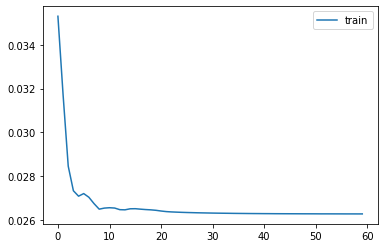

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = model.predict([test_roll,test_onehot_data],batch_size=5)

RMSE = sqrt(mean_squared_error(y_test_roll, predictions))

print(f'{RMSE:.5f}')

715/715 [==============================] - 4s 5ms/step
0.47520


### End of notebook

In [ ]:
from pip._internal.utils.misc import get_installed_distributions
import sys
#import numpy as np # imported to test whether numpy shows up, which it does!

def get_imported_packages():
    p = get_installed_distributions()
    p = {package.key:package.version for package in p}

    imported_modules = set(sys.modules.keys())
    
    imported_modules.remove('pip')

    modules = [(m, p[m]) for m in imported_modules if p.get(m, False)]

    return modules


def generate_requirements(filepath:str, modules):
    with open(filepath, 'w') as f:
        for module, version in modules:
            f.write(f"{module}=={version}")


generate_requirements('requirements.txt', get_imported_packages())